# Import des librairies

***

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0, MobileNet, ResNet50V2, VGG19
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adamax
import os
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import time
import random   

# Vérification des versions de TensorFlow et Keras

***

In [2]:
# Check Keras version
keras_version = keras.__version__
# Check Keras version
tf_version = tf.__version__


print("Keras version:", keras_version)
print("Tensorflow version : ", tf_version)

Keras version: 2.9.0
Tensorflow version :  2.9.1


# Variables d'environnement

***

Renseigner le répertoire contenant le dataset à utiliser

Choisir les poids à utiliser pour l'entrainement pour favoriser la détection d'une des des classes

In [3]:
# Chemins des dossiers
DATA_DIR = r'C:\Users\Morvan\OneDrive\Documents\DATA\projet_covid\COVID-PROJET\DATASETS\DATASET V2V2  - équilibré -augmenté_split'
train_dir = DATA_DIR + '/train'
val_dir = DATA_DIR + '/val'
test_dir = DATA_DIR + '/test'

# Paramètres
batch_size = 32
img_height = 224
img_width = 224


# Poids de classes (à adapter selon ton jeu de données ou préférences)
# Exemple : favoriser la détection de la classe 0 et sous-pondérer la 3 
class_weights = {
    0: 3.0,     # COVID
    1: 1.0,     #Lung_Opacity
    2: 1.0,     # Normal
    3: 1.0      # Viral Pneumonia
}

weight_code = ''
for value in class_weights.values():
    weight_code += str(int(value))  #mise en forme x111 pour l'enregistrement

# Chargement des datasets

***

In [4]:
# Chargement des datasets
train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)
classes_names = train_ds.class_names
num_classes = len(classes_names)

# Préparation des datasets (préchargement et préfetch)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Conversion N&B -> 3 canaux pour EfficientNet (qui attend des images en 3 canaux)
def convert_grayscale_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_ds = train_ds.map(convert_grayscale_to_rgb)
val_ds = val_ds.map(convert_grayscale_to_rgb)
test_ds = test_ds.map(convert_grayscale_to_rgb)

Found 15597 files belonging to 4 classes.
Found 3599 files belonging to 4 classes.
Found 4804 files belonging to 4 classes.


# Définition des modèles

***

<div class="alert alert-block alert-info">
<b>Attention :</b> Choisir le nom de modèle adéquat

Exécuter la cellule correspondant au modèle choisi (parmi EfficientNetB0, MobileNet, ResNet50V2, VGG19)

Les modèles seront timestampés à leur <u>__création__</u>.
</div>

##### Définition du modèle et compilation du modèle EfficientNet

In [6]:
# Création du nom du modèle et du chemin d'enregistrement + répertoire

model_name = 'EfficientNetB0'
timestr = time.strftime("%Y%m%d-%H%M%S")
model_full_name = f'{model_name}_{timestr}_{weight_code}'
model_path=f'models/{model_full_name}'
os.makedirs(model_path, exist_ok=True)

# Construction du modèle EfficientNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # on freeze le modèle pour commencer

for layer in base_model.layers:
    layer.trainable = False  # on freeze les couches du modèle de base

for layer in base_model.layers[-3:]:    
    layer.trainable = True  # on défreeze les 3 dernières couches
    print(f"Layer {layer.name} is trainable: {layer.trainable}")
# Ajout de la tête de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

# Compilation du modèle
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
#Callbacks

checkpoint_cb = ModelCheckpoint(
    filepath=f"{model_path}/{model_full_name}.keras",
    monitor="val_loss",
    save_best_only=True,
    mode ='min',
)
callbacks = [checkpoint_cb]


Layer top_conv is trainable: True
Layer top_bn is trainable: True
Layer top_activation is trainable: True


##### Définition du modèle et compilation du modèle MobileNet

In [5]:
# Création du nom du modèle et du chemin d'enregistrement + répertoire

model_name = 'MobileNet'
timestr = time.strftime("%Y%m%d-%H%M%S")
model_full_name = f'{model_name}_{timestr}_{weight_code}'
model_path=f'models/{model_full_name}'
os.makedirs(model_path, exist_ok=True)

# === Construction du modèle ===
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
checkpoint_cb = ModelCheckpoint(
    filepath=f"{model_path}/{model_full_name}.keras",
    monitor="val_loss",
    save_best_only=True,
)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    checkpoint_cb
]

##### Définition du modèle et compilation du modèle VGG19

In [ ]:
# Création du nom du modèle et du chemin d'enregistrement + répertoire
model_name = 'VGG19'
timestr = time.strftime("%Y%m%d-%H%M%S")
model_full_name = f'{model_name}_{timestr}_{weight_code}'
model_path=f'models/{model_full_name}'
os.makedirs(model_path, exist_ok=True)


# Création de la fonction du modèle avec VGG19
def build_model(input_shape=(224, 224, 3), num_classes=len(classes_names)):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape, pooling="max")
    # Gèle toutes les couches du modèle de base
    for layer in base_model.layers:
        layer.trainable = False
    # Déverrouille uniquement la couche 'block5_conv4'
    for layer in base_model.layers:
        if layer.name == 'block5_conv4':
            layer.trainable = True
            print(f"Déverrouillage de : {layer.name}")
    x = base_model.output # permet la lecture des couches pour une analyse d'interprétabilité
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    # Recompile le modèle après modification des couches entraînables
    model.compile(optimizer=Adamax(learning_rate=0.0001),  # Learning rate plus bas pour le fine-tuning
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
# Fonction des callback

def get_callbacks():
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
    checkpoint = ModelCheckpoint(f'{model_path}/{model_full_name}.h5', monitor='val_loss', save_best_only=True, verbose=1)
    log_dir = f"{model_path}/logs/fit/{timestr}"
    tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
    return [early_stop, reduce_lr, checkpoint, tensorboard]
# Création du modèle


model = build_model()
callbacks = get_callbacks()

##### Définition du modèle et compilation du modèle ResNet

In [ ]:
# Création du nom du modèle et du chemin d'enregistrement + répertoire
model_name = 'ResNet50V2'
timestr = time.strftime("%Y%m%d-%H%M%S")
model_full_name = f'{model_name}_{timestr}_{weight_code}'
model_path=f'models/{model_full_name}'
os.makedirs(model_path, exist_ok=True)

## Structure générale du modèle

# Charger le modèle ResNet50V2 sans la partie supérieure
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# On "freeze" le modèle de base
base_model.trainable = False

# "Freezer" les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# "Défreezer" les couches du modèle de base
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Construction du modèle (partie top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(rate = 0.2)(x) # Couche de Dropout pour éviter l'overfitting
x = Dense(512, activation = 'relu')(x)
x = Dropout(rate = 0.2)(x) # Couche de Dropout pour éviter l'overfitting
outputs = Dense(num_classes, activation='softmax')(x) # 4 classes de radiographies

# Instanciation du modèle
model = Model(inputs = base_model.input, outputs = outputs)


## Compilation du modèle

# Création fct de perte
opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

# Compilation
model.compile(loss = 'categorical_crossentropy',
                     optimizer = opt,
                     metrics = ['accuracy']
                     )

## Instanciation callbacks

# a) Arrêt prématuré

early_stopping = EarlyStopping(monitor = 'val_loss',       # Métrique surveillée
                               min_delta = 0.01,           # Changement minimum de la métrique surveillée
                               patience = 5,               # Nombre d'epochs sans amélioration pour arrêt
                               mode = 'min',               # L'entraînement s'arrête quand 'val_loss' cesse de décroître
                               verbose = 1,                # Affichage de l'epoch d'arrêt
                               restore_best_weights = True # Restauration des meilleurs poids (après arrêt)
                              )


## b) Learning_rate réduit
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',       # Métrique surveillée
                                         min_delta = 0.01,           # Changement minimum de la métrique surveillée
                                         patience = 3,               # Nombre d'epochs sans amélioration pour arrêt
                                         factor = 0.1,               # Learning_rate divisé par 10 (multiplié par 0.1)
                                         cooldown = 4,               # Pause de 4 epochs entre 2 cycles
                                         verbose = 1,                # Affichage de l'epoch d'arrêt
                                         restore_best_weights = True # Restauration des meilleurs poids (après arrêt)
                                        )


## c) Sauvegarde auto du modèle durant l'entraînement



save0 = ModelCheckpoint(f"{model_path}/{model_full_name}.keras",
                       save_best_only=True, # Only saves when the model is considered the "best"
                       monitor='val_loss', # The metric name to monitor
                       mode='min' # Overwrite elder model when 'val_loss' is min
                      )
save1 = ModelCheckpoint(f"{model_path}/{model_full_name}.h5",
                       save_best_only=True, # Only saves when the model is considered the "best"
                       monitor='val_loss', # The metric name to monitor
                       mode='min' # Overwrite elder model when 'val_loss' is min
                      )



callbacks = [early_stopping,
            reduce_learning_rate,
            save0, save1]


# Résumé et entraînement du modèle

***

Choisir le nombre d'époques sur lequel entraîner le modèle

In [6]:
#Choix du nombre d'époques
nb_epochs = 2

In [7]:
# Résumé du modèle
model_summary = model.summary()
print(model_summary)

#  Appliquer le prétraitement adéquat
preprocess_dict = {
    'EfficientNetB0': efficientnet_preprocess_input,
    'MobileNet': mobilenet_preprocess_input,
    'ResNet50V2': resnet_preprocess_input,
    'VGG19': vgg_preprocess_input
}
preprocess_input = preprocess_dict[model_name]
train_ds_preprocessed = train_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)
val_ds_preprocessed = val_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)
test_ds_preprocessed = test_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)

# Entraînement
history = model.fit(
    train_ds_preprocessed,
    validation_data=val_ds_preprocessed,
    epochs=nb_epochs,
    class_weight=class_weights,
    callbacks=callbacks,
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

# Affichage des courbes d'entraînement

***

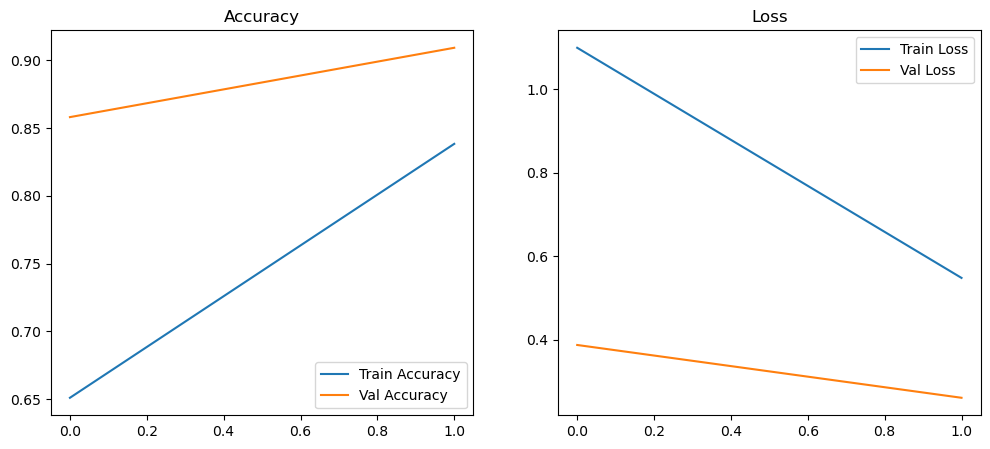

In [8]:
# Affichage des courbes de performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Courbe Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

# Courbe Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.savefig(f"{model_path}/training_history.png")
plt.show()

# Sauvegarde et chargement du modèle (si nécessaire)

***

In [ ]:
# Sauvegarde du modèle

model.save(f"{model_path}/{model_full_name}.keras")

# Chargement du modèle

#model = tf.keras.models.load_model(r'C:\Users\Morvan\OneDrive\Documents\DATA\projet_covid\COVID-PROJET\models\efficientnet_20250520-225911_3111\efficientnet_20250520-225911_3111.keras')

# Prediction sur le jeu de test

***

151/151 [==============================] - 35s 226ms/step


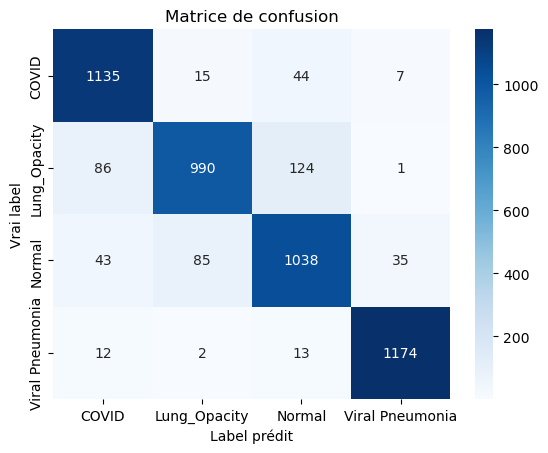

📄 Rapport de classification
                 precision    recall  f1-score   support

          COVID      0.889     0.945     0.916      1201
   Lung_Opacity      0.907     0.824     0.863      1201
         Normal      0.852     0.864     0.858      1201
Viral Pneumonia      0.965     0.978     0.971      1201

       accuracy                          0.903      4804
      macro avg      0.903     0.903     0.902      4804
   weighted avg      0.903     0.903     0.902      4804



In [9]:
y_true = np.concatenate([label.numpy() for _, label in test_ds_preprocessed])
y_true_labels = np.argmax(y_true, axis=1)

# Prédictions

y_pred_probs = model.predict(test_ds_preprocessed)
y_pred_labels = np.argmax(y_pred_probs, axis=1)


# Matrice de confusion
cm = confusion_matrix(y_true_labels, y_pred_labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes_names, yticklabels=classes_names)
plt.ylabel('Vrai label')
plt.xlabel('Label prédit')
plt.title('Matrice de confusion')
#plt.savefig(f"{model_path}/confusion_matrix.png")
plt.show()
# Rapport de classification
print("📄 Rapport de classification")
cr = classification_report(y_true_labels, y_pred_labels, target_names=classes_names, digits=3)
print(cr)

f = open(f"{model_path}/report_{model_full_name}.txt", 'w')
f.write('Title\n\nClassification Report\n\n{}\n\nConfusion Matrix\n\n{}\n'.format(cr, cm))
f.close()

# Résultats détaillés

***

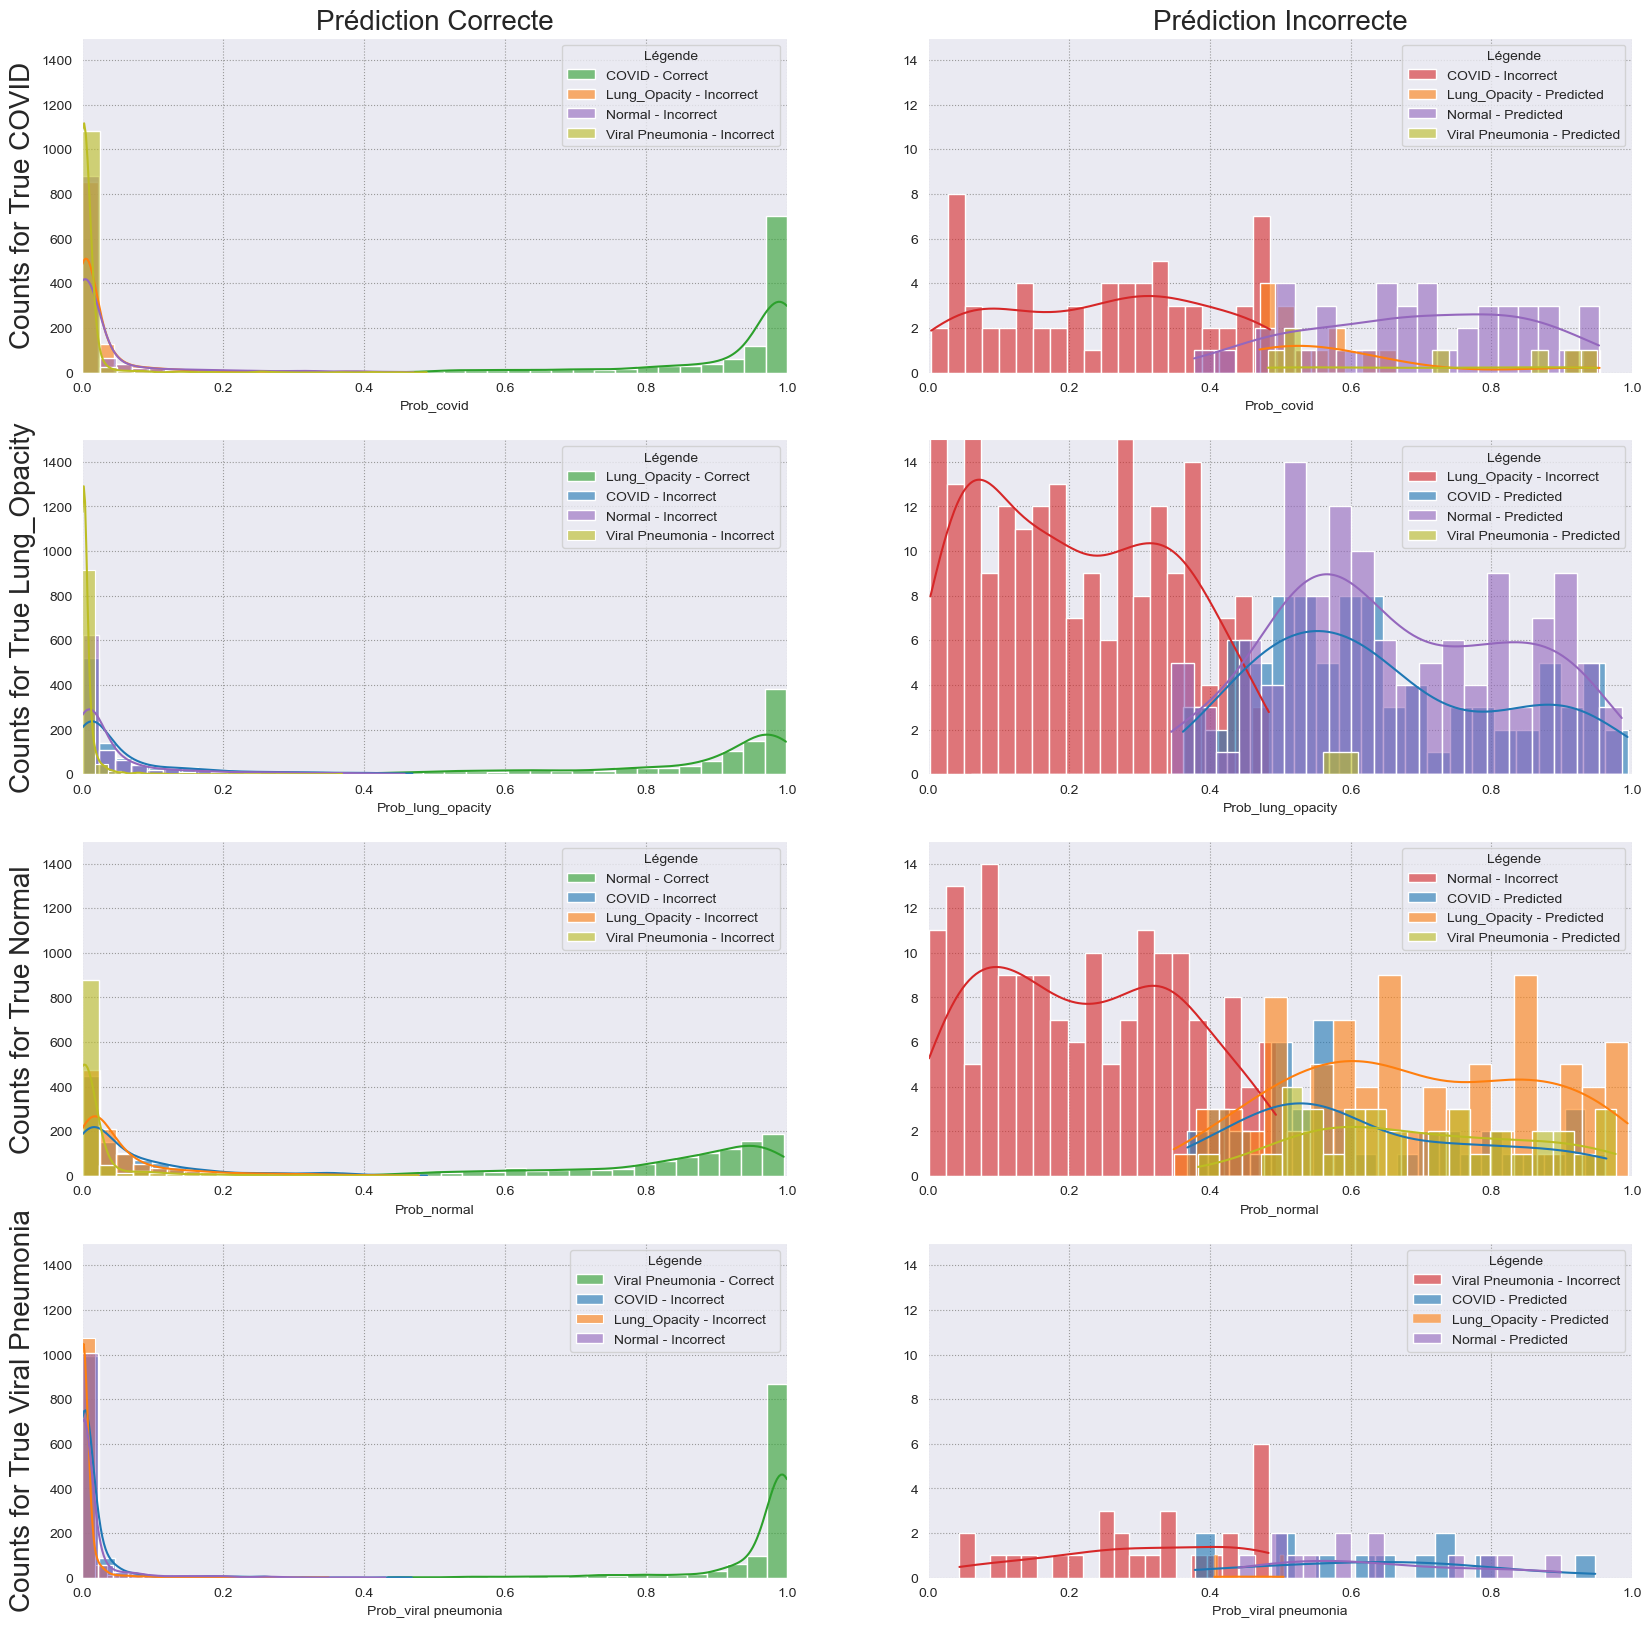

In [10]:
correct_predictions = y_true_labels == y_pred_labels
y_pred_class = [classes_names[i] for i in y_pred_labels]
y_true_class = [classes_names[i] for i in y_true_labels]
predicted_probs = y_pred_probs.max(axis=1)
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
colors=sns.color_palette()             

def remove_value(value, lst):
    return [x for x in lst if x != value]

class_colors = {
    'COVID': colors[0],
    'Lung_Opacity': colors[1],
    'Normal': colors[4],
    'Viral Pneumonia': colors[8]
}
df_summary = pd.DataFrame({
    'Prob_COVID': y_pred_probs[:, 0],
    'Prob_Lung_Opacity': y_pred_probs[:, 1],
    'Prob_Normal': y_pred_probs[:, 2],
    'Prob_Viral Pneumonia': y_pred_probs[:, 3],
    'Predicted Probability': predicted_probs,
    'Unpredicted Probability': 1 - predicted_probs,
    'Pred_class': y_pred_class,
    'True_class': y_true_class,
    'Correct Prediction': correct_predictions
})

i=0
plt.figure(figsize=(20, 20))
for class_name in classes_names:
    for correct in [True, False]:
        i += 1
        ax1 = plt.subplot(4, 2, i)
        df_filtered = df_summary[(df_summary['Correct Prediction'] == correct) & (df_summary['True_class'] == class_name)]
        if correct:
            sns.histplot(df_filtered, x=f'Prob_{class_name}', bins=20, color=colors[2], label=f'{class_name} - Correct', alpha=0.6, kde=True)

            for other_class in remove_value(class_name, classes_names):
                sns.histplot(df_filtered, x=f'Prob_{other_class}', bins=20, alpha=0.6, label=f'{other_class} - Incorrect', color=class_colors[other_class], kde=True)
            #sns.histplot(df_filtered, x=f'Predicted Probability', bins=20, hue='Pred_class', multiple='dodge')
            hndls, lbls = plt.gca().get_legend_handles_labels()
            plt.legend(handles=hndls, labels=lbls, title="Légende")
            ax1.set_ylim([0, 15])
            plt.ylabel(None)
            plt.ylabel(f'Counts for True {class_name}', fontsize=20)
            ax1.set_xlim(0.4, 1)
            ax1.set_ylim([0, 1500])
            plt.title(f'Prédiction Correcte', fontsize=20) if i == 1 else None
            
        else:
            sns.histplot(df_filtered, x=f'Prob_{class_name}', bins=20, color=colors[3], alpha=0.6, label=f'{class_name} - Incorrect', kde=True)

            for other_class in remove_value(class_name, classes_names):
                sns.histplot(df_filtered[df_filtered['Pred_class']== other_class], x=f'Predicted Probability', bins=20, alpha=0.6, label=f'{other_class} - Predicted', color=class_colors[other_class], kde=True)
            #sns.histplot(df_filtered, x=f'Predicted Probability', bins=20, hue='Pred_class', multiple='dodge')
            hndls, lbls = plt.gca().get_legend_handles_labels()
            plt.legend(handles=hndls, labels=lbls, title="Légende")
            ax1.set_ylim([0, 15])
            plt.ylabel(None)

            plt.title(f'Prédiction Incorrecte', fontsize=20) if i == 2 else None
        plt.xlim(0, 1)
                
        plt.xlabel(f'Prob_{class_name.lower()}')

plt.savefig(f"{model_path}/histograms.png")
plt.show()

# Affichage GRAD-CAM

***

4/4 [==============================] - 1s 165ms/step


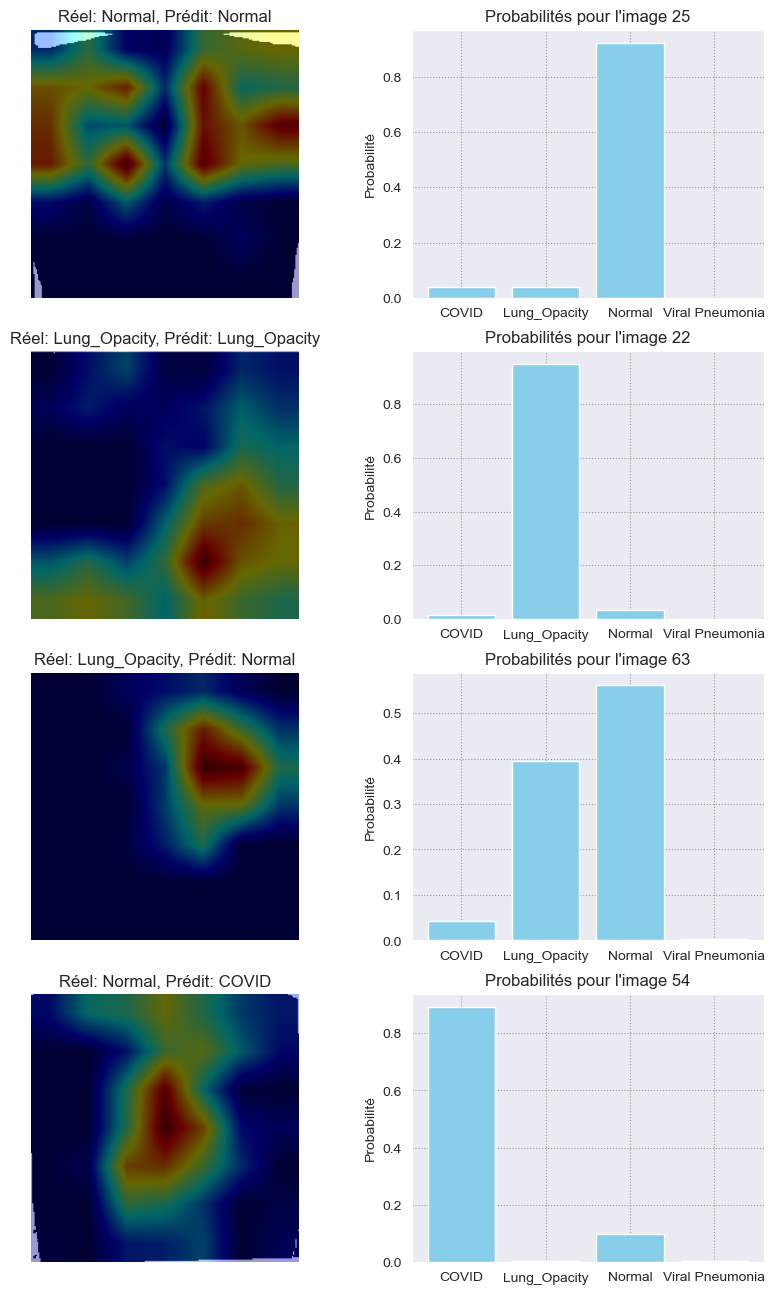

In [11]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


# Récupérer les images et labels
test_images = []
test_labels = []


# Dé-unbatch et convertit en liste
all_test_data = list(test_ds.unbatch().as_numpy_iterator())

# Tire 100 échantillons au hasard (ou moins si moins de 100 dans le dataset)
selected_samples = random.sample(all_test_data, k=min(100, len(all_test_data)))

# Sépare images et labels
original_images = [img.copy() for img, label in selected_samples]
test_labels = [np.argmax(label) for img, label in selected_samples]

# Applique le pré-processing
preprocess_input = preprocess_dict[model_name]
test_images = np.array([preprocess_input(img) for img in original_images])
test_labels = np.array(test_labels)



# Prédictions sur ces images
pred_probs = model.predict(test_images)
pred_labels = np.argmax(pred_probs, axis=1)

# Trouver 2 bonnes et 2 mauvaises
correct_idx = np.where(pred_labels == test_labels)[0]
incorrect_idx = np.where(pred_labels != test_labels)[0]


selected_correct = np.random.choice(correct_idx, size=min(2, len(correct_idx)), replace=False)
selected_incorrect = np.random.choice(incorrect_idx, size=min(2, len(incorrect_idx)), replace=False)
# Fusion
selected_idx = np.concatenate([selected_correct, selected_incorrect])

# Grad-CAM et affichage


# Trouver le nom de la dernière couche de convolution
last_conv_layer_name = next((l.name for l in reversed(model.layers) if "conv" in l.name), None)

fig, axes = plt.subplots(4, 2, figsize=(10, 16))
axes = axes.flatten()

for i, idx in enumerate(selected_idx):
    img_array = np.expand_dims(original_images[idx], axis=0)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Superposer heatmap à l’image
    img = original_images[idx].astype('uint8')
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255*heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), 0.6, heatmap_colored, 0.4, 0)

    
    ax = axes[2*i]
    ax.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Réel: {classes_names[test_labels[idx]]}, Prédit: {classes_names[pred_labels[idx]]}")
    ax.axis('off')

    ax = axes[2*i+1]
    probs = pred_probs[idx]
    classes = [f'Classe {i}' for i in range(len(probs))]
    ax.bar(classes_names, probs, color='skyblue')
    ax.set_title(f'Probabilités pour l\'image {idx}')
    ax.set_ylabel('Probabilité')

if not os.path.exists(f"{model_path}/gradcam"):
    os.makedirs(f"{model_path}/gradcam")
timestamp = time.strftime("%Y%m%d-%H%M%S")
plt.savefig(f"{model_path}/gradcam/gradcam_{timestamp}.png")